In [2]:
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [3]:
import random
random.seed(1)
# base station location
base_X = 25
base_Y = -100
# transmission energy and receive energy J/bit
ETx = 50*0.000000001
ERc = ETx
# amplification coefficientds J/bit/m^2
epsilon_amp = 10*0.000000000001
# number of clusters
num_clusters = 5
# number of nodes
num_nodes = 100
# initial energy of one node
energy = 0.5
# size of a packet
packet_bit = 2000
# aggregation energy
aggr = 5*0.000000001
# gather x bits together and aggregate them into 0.3 * x bits
aggr_rate = 0.25
# P and 1/P calculating threshould
P = num_clusters / (num_nodes * 1.0)
one_by_P = num_nodes // num_clusters

In [92]:
# cluster class
class Cluster:
    def __init__(self):
        # nodes in one cluster
        self.nodes = []
        # cluster head, type (node)
        self.head = None
        # number of bits awaiting aggregation
        self.bits = 0
    
    # add one node into the cluster
    def add(self, node):
        self.nodes.append(node)
      
    # tell whether the node is the cluster head
    def is_head(self, node):
        return node == self.head
    
    # quick calculation of the square of distance between one node and the cluster head
    def dis(self, node):
        return distance(node.X, self.head.X, node.Y, self.head.Y)

In [5]:
# square of distance instead of distance
def distance(x_1, x_2, y_1, y_2):
    return (x_1 - x_2)**2 + (y_1 - y_2)**2

In [6]:
def T(r):
    #print(P, one_by_P, r, P / (1 - P * (r % one_by_P)))
    return P / (1 - P * (r % one_by_P))

In [72]:
import random

class Node:
    def __init__(self, x, y):
        # (X,Y)
        self.X = x
        self.Y = y
        # remaining energy
        self.energy = energy
        # false means the nodes alive, otherwise dead
        self.die = False
        self.last = -1
        self.cluster = None
    
    def elect(self, r, clusters):
        self.cluster = None
        if r % one_by_P == 0:
            self.last = -1
        if (self.last == -1 or self.last + one_by_P <= r % one_by_P) and not self.die:
            if random.uniform (0,1) <= T(r):
                cluster = Cluster()
                cluster.add(self)
                cluster.head = self
                clusters.append(cluster)
                self.last = r
                self.cluster = cluster
                #print(r, len(clusters))
    
    def select(self, r, clusters):
        if self.cluster != None:
            return
        min_dis = 100000000
        cluster = -1
        for i in range(len(clusters)):
            if min_dis > clusters[i].dis(self):
                cluster = i
                min_dis = clusters[i].dis(self)
        #print(len(clusters), cluster)
        if cluster == -1:
            return
        clusters[cluster].add(self)
        self.cluster = clusters[cluster]
    
    def direct(self):
        transmission = ETx * packet_bit
        amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
        if self.energy < transmission + amplification:
            self.die = True
        else:
            self.energy -= (transmission + amplification)
    
    def send(self):
        if self.cluster.is_head(self):
            if self.cluster.bits == 0:
                transmission = ETx * packet_bit
                amplification = epsilon_amp * packet_bit * distance(self.X, base_X, self.Y, base_Y)
                if self.energy < transmission + amplification:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification)
            else:
                transmission = ETx * aggr_rate * (packet_bit + self.cluster.bits)
                amplification = epsilon_amp * aggr_rate * (packet_bit + self.cluster.bits) * distance(self.X, base_X, self.Y, base_Y)
                #print(transmission, amplification, aggr, self.energy)
                if self.energy < transmission + amplification + aggr:
                    self.die = True
                else:
                    self.energy -= (transmission + amplification + aggr)
                self.cluster.bits = 0
        else:
            if self.cluster.head.die:
                self.die = True
                return
            transmission = ETx * packet_bit
            amplification = epsilon_amp * packet_bit * self.cluster.dis(self)
            if self.energy < transmission + amplification:
                self.die = True
            else:
                self.energy -= (transmission + amplification)
            receive = ERc * packet_bit
            self.cluster.head.energy -= receive
            self.cluster.bits += packet_bit

In [110]:
num_nodes = 100
Xs = uniform.rvs(loc=0, scale=60, size=num_nodes)
Ys = uniform.rvs(loc=0, scale=60, size=num_nodes)

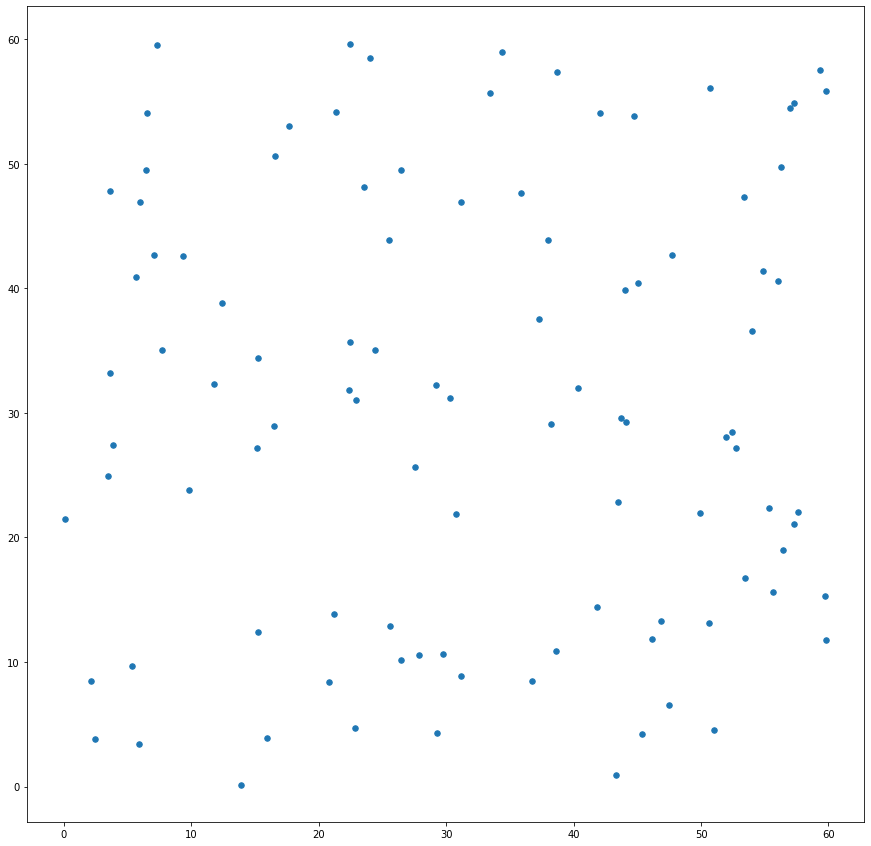

In [111]:
plt.figure(figsize=(15, 15))
plt.scatter(Xs, Ys, s = 30)

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 0
1200 number of nodes dead 3
1600 number of nodes dead 47
2000 number of nodes dead 93
2400 number of nodes dead 100


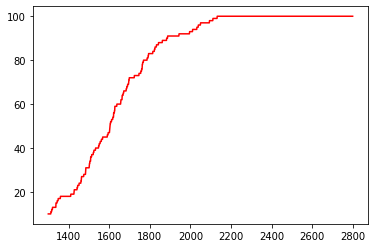

In [120]:
packet_bit = 2000
energy = 0.5
num_rounds = 2800
random.seed(1)
color = ['red', 'blue', 'green', 'yellow', 'purple']
index = -1
for k in [1]:
    index += 1
    Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
    clusters = []
    dead = []
    num = []
    P = 0.05
    one_by_P = 1/P
    for i in range(num_rounds):
        if i%400 == 0:
            print(i, "number of nodes dead", len(dead))
        num.append(len(dead))
        #print("energy", Nodes[0].energy)
        clusters = []
        for node in Nodes:
            node.elect(i, clusters)
        if len(clusters) == 0:
            #print(i, "PPPPPPPPPP", P, T(i))
            #P = 5/(num_nodes - len(dead) + 1)
            #P *= k
            #P = min(1, P)
            #one_by_P = 1/P
            for j in range(num_nodes):
                if j not in dead:
                    Nodes[j].direct()
                    if Nodes[j].die:
                        dead.append(j)
        else:
            for node in Nodes:
                node.select(i, clusters)
            for j in range(num_nodes):
                if j not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)
            for j in range(num_nodes):
                if j not in dead and Nodes[j].cluster.is_head(Nodes[j]):
                    Nodes[j].send()
                    if Nodes[j].die:
                        dead.append(j)

    plt.plot(range(num_rounds)[1300:], num[1300:], color = color[index])

In [127]:
dis_vec = []
for i in range(100):
    li = []
    for j in range(100):
        dis = distance(Xs[i], Xs[j], Ys[i], Ys[j])
        li.append([dis, j])
    #li.sort(key=lambda x: x[0])
    #li = li[1:]
    dis_vec.append(np.asarray(li))
dis_vec = np.asarray(dis_vec)

clusters = [[i] for i in range(100)]
def cluster_dis(i, j):
    list = [np.mean(dis_vec[k, clusters[j], 0]) for k in clusters[i]]
    return np.mean(list)

while len(clusters) > 5:
    min = float('inf')
    temp_i = -1
    temp_j = -1
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            if cluster_dis(i, j) < min:
                min = cluster_dis(i, j)
                temp_i = i
                temp_j = j
    new_clusters = []
    new_clusters.append(np.append(clusters[temp_i], clusters[temp_j]).tolist())
    for i in range(len(clusters)):
        if i != temp_i and i != temp_j:
            new_clusters.append(clusters[i])
    clusters = new_clusters

print(len(clusters))  

5


In [128]:
print(clusters)

[[37, 50, 3, 6, 28, 56, 81, 19, 68, 55, 40, 71, 11, 17, 89, 47, 49, 62, 94, 43, 85, 1], [42, 97, 78, 93, 70, 75, 91, 95, 86, 58, 72, 48, 7, 23, 14, 99], [15, 84, 9, 27, 53, 20, 76, 74, 16, 31, 73, 26, 96, 29, 87, 8, 90, 0, 69], [51, 98, 34, 92, 4, 60, 22, 82, 5, 77, 64, 13, 25, 80, 38, 52, 61, 33, 83, 36, 59, 41, 44, 79, 45, 66, 65], [18, 57, 32, 10, 21, 39, 35, 67, 12, 30, 88, 2, 63, 24, 54, 46]]


22 7
16 9
19 3
27 23
16 12


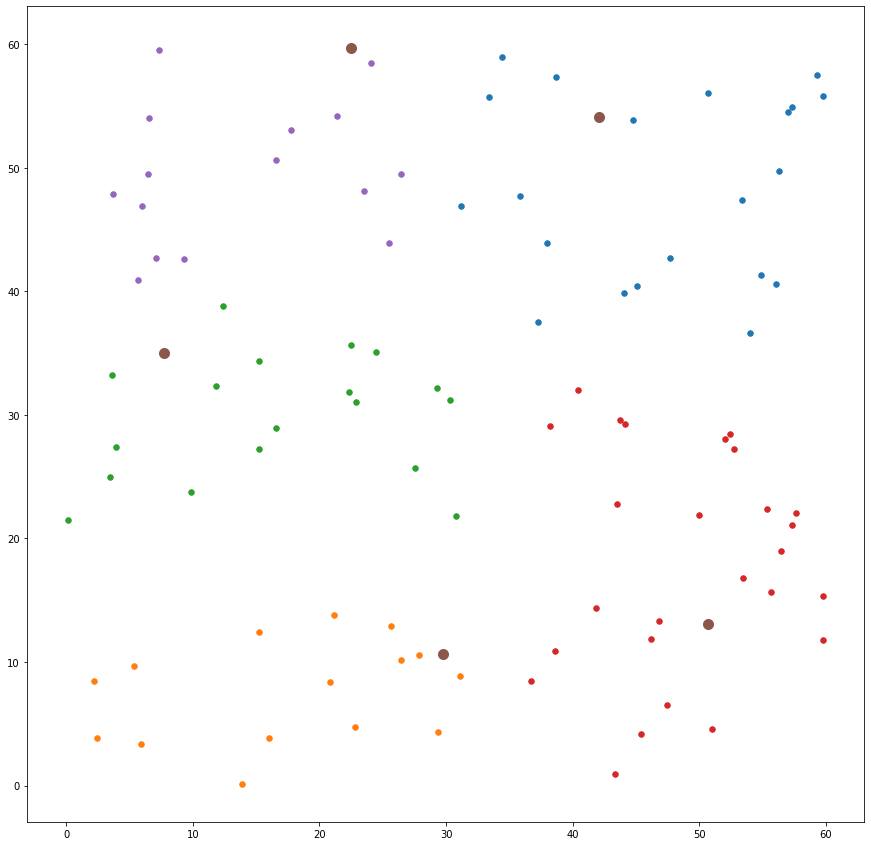

In [129]:
A = clusters
X0 = [Xs[i] for i in A[0]]
Y0 = [Ys[i] for i in A[0]]
X1 = [Xs[i] for i in A[1]]
Y1 = [Ys[i] for i in A[1]]
X2 = [Xs[i] for i in A[2]]
Y2 = [Ys[i] for i in A[2]]
X3 = [Xs[i] for i in A[3]]
Y3 = [Ys[i] for i in A[3]]
X4 = [Xs[i] for i in A[4]]
Y4 = [Ys[i] for i in A[4]]
plt.figure(figsize=(15, 15))
plt.scatter(X0, Y0, s = 30)
plt.scatter(X1, Y1, s = 30)
plt.scatter(X2, Y2, s = 30)  
plt.scatter(X3, Y3, s = 30)
plt.scatter(X4, Y4, s = 30) 
random.seed(4)
a = random.randint(0, len(A[0]) - 1)
b = random.randint(0, len(A[1]) - 1)
c = random.randint(0, len(A[2]) - 1)
d = random.randint(0, len(A[3]) - 1)
e = random.randint(0, len(A[4]) - 1)
print(len(A[0]), a)
print(len(A[1]), b)
print(len(A[2]), c)
print(len(A[3]), d)
print(len(A[4]), e)
plt.scatter([X0[a], X1[b], X2[c], X3[d], X4[e]], [Y0[a], Y1[b], Y2[c], Y3[d], Y4[e]], s = 100)

0 number of nodes dead 0
400 number of nodes dead 0
800 number of nodes dead 1
1200 number of nodes dead 11
1600 number of nodes dead 52
2000 number of nodes dead 82
2400 number of nodes dead 97


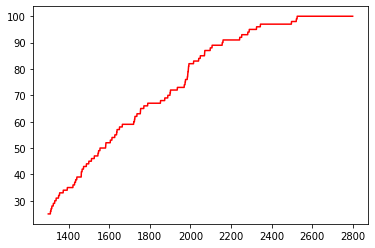

In [134]:
num_rounds = 2800
Nodes = [Node(Xs[i], Ys[i]) for i in range(num_nodes)]
dead = []
nums = []
C = [Cluster() for i in range(num_clusters)]
j = -1
for i in range(num_rounds):
    nums.append(len(dead))
    if i%400 == 0:
        print(i, "number of nodes dead", len(dead))
    j = 0
    for cluster in clusters:
        head = cluster[i % len(cluster)]
        C[j].head = Nodes[head]
        k = 0
        while k < 100:
            head = cluster[(i + k) % len(cluster)]
            if not Nodes[head].die:
                C[j].head = Nodes[head]
                break
            k += 1
        j += 1
    for node in Nodes:
        node.select(i, C)
    #print(Nodes[10].cluster.head.X)
    for k in range(num_nodes):
        if k not in dead and not Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)
    for k in range(num_nodes):
        if k not in dead and Nodes[j].cluster.is_head(Nodes[j]):
            if Nodes[k].cluster.head.die:
                Nodes[k].direct()
            else:
                Nodes[k].send()
            if Nodes[k].die:
                dead.append(k)

plt.plot(range(num_rounds)[1300:], nums[1300:], color = color[index])

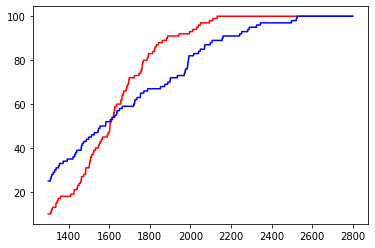

In [135]:
plt.plot(range(num_rounds)[1300:], num[1300:], color = "red")
plt.plot(range(num_rounds)[1300:], nums[1300:], color = "blue")

0 number of nodes dead 0
10 number of nodes dead 0
20 number of nodes dead 0
30 number of nodes dead 0
40 number of nodes dead 0
50 number of nodes dead 0
60 number of nodes dead 0
70 number of nodes dead 0
80 number of nodes dead 0
90 number of nodes dead 0
100 number of nodes dead 24
110 number of nodes dead 42
120 number of nodes dead 57
130 number of nodes dead 70
140 number of nodes dead 79
150 number of nodes dead 84
160 number of nodes dead 97
170 number of nodes dead 100
180 number of nodes dead 100
190 number of nodes dead 100
200 number of nodes dead 100
210 number of nodes dead 100
220 number of nodes dead 100
230 number of nodes dead 100
240 number of nodes dead 100


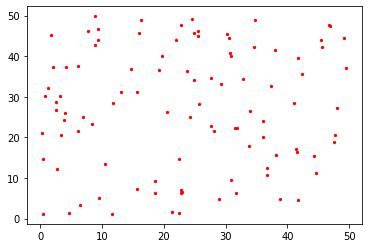

In [13]:
Nodes = [None for i in range(num_nodes)]

for i in range(num_nodes):
    Nodes[i] = Node(Xs[i], Ys[i])
num2 = []
dead = []
for i in range(250):
    num2.append(len(dead))
    if i%10 == 0:
        print(i, "number of nodes dead", len(dead))
    #print(Nodes[0].energy)
    for j in range(num_nodes):
        if j not in dead:
            Nodes[j].direct()
            if Nodes[j].die:
                dead.append(j)
                
dead_X = []
dead_Y = []
undead_X = []
undead_Y = []
for i in range(num_nodes):
    if i in dead:
        dead_X.append(Xs[i])
        dead_Y.append(Ys[i])
    else:
        undead_X.append(Xs[i])
        undead_Y.append(Ys[i])
plt.scatter(dead_X, dead_Y, s = 5, color = 'red')
plt.scatter(undead_X, undead_Y, s = 5, color = 'blue')

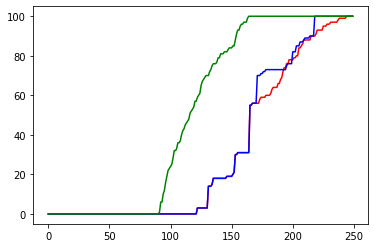

In [34]:
plt.plot(range(250), num, color = 'r')
plt.plot(range(250), num1, color = 'b')
plt.plot(range(250), num2, color = 'g')